In [1]:
import cv2
import numpy as np
from neuralnetworks.convlstm import ConvLSTM

ModuleNotFoundError: No module named 'neuralnetworks'

### Video Processing
First, let us process a single video into the individual frames

In [109]:
# def extract_frames(video_path: str):
#     cap = cv2.VideoCapture(video_path)
#     frames = []
    
#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             break
#         frames.append(cv2.resize(frame, (64, 64)))  # Resize to reduce complexity
#     cap.release()
#     return frames

We will prepare the training data such that the sequence length is 5 (The model will receive 5 consecutive frames and then generate the following frame conditionally)

In [110]:
# def prepare_train_data(frames, sequence_length: int = 5):
#     sequence_length = 5  # 3-5 frames as input, adjust as needed
#     X, y = [], []

#     for i in range(len(frames) - sequence_length):
#         X.append(frames[i:i + sequence_length])  # Input sequence
#         y.append(frames[i + sequence_length])    # Next frame to predict

#     # Convert to numpy arrays and normalize
#     X = np.array(X) / 255.0
#     y = np.array(y) / 255.0
#     print(X.shape)
#     X = X.transpose(0, 1, 4, 3, 2)  # New shape: (num_samples, sequence_length, channels, height, width)
#     y = y.transpose(0, 3, 2, 1) 

#     return X,y

In [111]:
from video_processing.prepare_data import extract_frames, prepare_train_data

In [112]:
frames = extract_frames(video_path="/Users/chrishon/capstone-camera-traps/resources/videos/FH102_02 (1).avi")

In [71]:
len(frames)//100

215

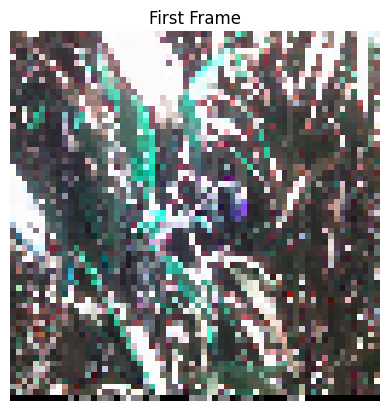

In [72]:
# Plot the first frame to visualize
plt.imshow(frames[20])  # Display the first frame
plt.title("First Frame")
plt.axis("off")  # Hide axes for better view
plt.show()

In [76]:
X,y = prepare_train_data(frames[:len(frames)//100])

(210, 5, 64, 64, 3)


In [77]:
print(X.shape, y.shape)

(210, 5, 3, 64, 64) (210, 3, 64, 64)


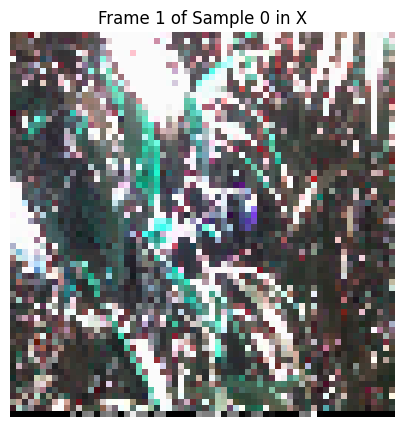

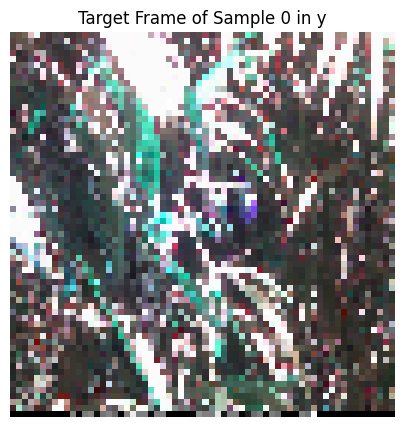

In [78]:
plt.figure(figsize=(5, 5))
plt.imshow(X[0, 0,:,:,:].swapaxes(0,-1))  # No need to permute since channels are last by default
plt.title(f"Frame {0 + 1} of Sample {0} in X")
plt.axis("off")
plt.show()

# Optionally, plot the target frame in y (the frame to predict)
plt.figure(figsize=(5, 5))
plt.imshow(y[0,:,:,:].swapaxes(0,-1))  # No need to permute
plt.title(f"Target Frame of Sample {0} in y")
plt.axis("off")
plt.show()

### Training the model

First, prepare the dataset for training

In [79]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader objects for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Now we will train a ConvLSTM model on this dataset

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [82]:
# Model parameters
input_dim = 3
hidden_dim = 64
kernel_size = 3
num_layers = 2
model = ConvLSTM(input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, num_layers=num_layers)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [83]:
device = torch.device('cuda') if  torch.cuda.is_available() else torch.device('cpu')

In [90]:
# Training loop
num_epochs = 10
batch_size = 8

for epoch in range(num_epochs):
    for batch_x, batch_y in train_loader: 
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 0.0152
Epoch [2/10], Loss: 0.0134
Epoch [3/10], Loss: 0.0110
Epoch [4/10], Loss: 0.0092
Epoch [5/10], Loss: 0.0099
Epoch [6/10], Loss: 0.0140
Epoch [7/10], Loss: 0.0092
Epoch [8/10], Loss: 0.0077
Epoch [9/10], Loss: 0.0093
Epoch [10/10], Loss: 0.0082


In [94]:
import matplotlib.pyplot as plt

In [95]:
model.eval()

ConvLSTM(
  (conv_lstm_cells): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(67, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (conv): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08586079..1.0393876].


torch.Size([1, 5, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])


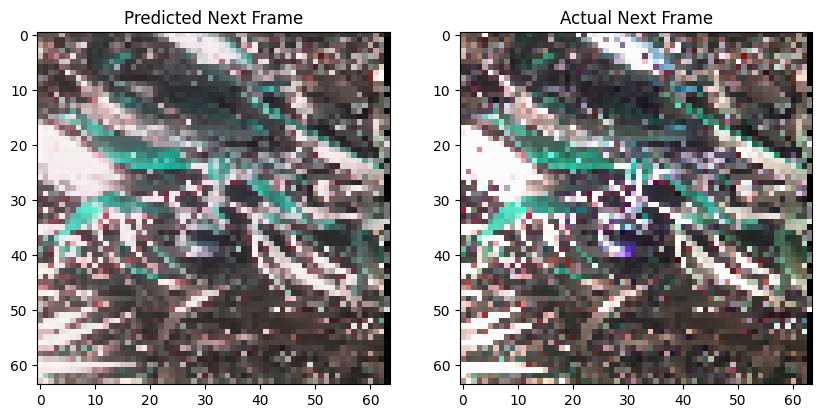

In [108]:
sample_idx = 0  # Index of the sample to test
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


sample_idx = 10  # Index of the sample to test
X_sample = X_test_tensor[sample_idx:sample_idx+1]  # Shape: (1, sequence_length,num_channels, height, width, )
print(X_sample.shape)

with torch.no_grad():
    prediction = model(X_sample)

# Extract the last predicted frame from the sequence
print(prediction.shape)
predicted_frame = prediction.cpu()
print(predicted_frame.shape)

# Check shape and adjust if necessary
if predicted_frame.ndim == 4:
    predicted_frame = predicted_frame.squeeze(0)  # Shape: (height, width, num_channels)

 
actual_next_frame = y_test_tensor[sample_idx].cpu()

# Plot the predicted and actual frames
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(predicted_frame.permute(1, 2, 0).numpy())  # Convert channels to last dimension for plotting
plt.title("Predicted Next Frame")

plt.subplot(1, 2, 2)
plt.imshow(actual_next_frame.permute(1, 2, 0).numpy())
plt.title("Actual Next Frame")

plt.show()